In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

# Data Pipeline

### Data Preprocessing

"there are no timestamps for time periods in which the exchange was down. Also if there were time periods without any activity or trades there will be no timestamp as well".

In [2]:
# transform the data to 5min resolution and fill the missing values
def to_5min_data(df):
    # Only consider data within 2019-01-01 to 2023-06-01, get one more day for the convenience of data processing
    df = df[(df.index >= pd.Timestamp('2018-12-31')) & (df.index <= pd.Timestamp('2023-06-02'))]
    
    df = df.resample('5T', label='right', closed='right').agg({'open':'first','close':'last','high':'max','low':'min','volume':'sum'})

    # if no valid trade happens, close = previous close price
    df['close'].ffill(inplace = True)

    # if no valid trade happens, high/low/open = previous close price
    df.fillna({'open':df['close'], 'high':df['close'], 'low':df['close']}, inplace=True)
    return df

# find all crypto assets with valid data under our requirement and generate the corresponding data file
def get_crypto_data(file_path, store_path):
    crypto_5min_data = {}
    print('Searching all csv file')
    for crypto_name in tqdm(os.listdir(file_path)):
        crypto_name = crypto_name.split('.csv')[0]
        if 'usd' in crypto_name:
            csv_path = os.path.join(file_path, '{}.csv'.format(crypto_name))
            df = pd.read_csv(csv_path, index_col='time')
            if df.empty:
                continue
            df.index = pd.to_datetime(df.index, unit='ms', errors='coerce')
            
            #Only consider the crypto with valid data between 20190101 and 20230601
            if (df.index[0] <= pd.Timestamp('2019-01-01')) and (df.index[-1] >= pd.Timestamp('2023-06-01')):
                crypto_5min_data[crypto_name] = to_5min_data(df)

    #combine the data of all the crypto
    combined_data = pd.concat(crypto_5min_data,axis = 0).reset_index(names = ['asset','time'])

    print('Generating data file')
    for field in tqdm(['open','close','high','low','volume']):
        combined_5min_data = combined_data.pivot(index = 'time', values = field, columns='asset')
        #save the price&volume data to store_path
        combined_5min_data = combined_5min_data[(combined_5min_data.index >= pd.Timestamp('2019-01-01')) 
                                                & (combined_5min_data.index <= pd.Timestamp('2023-06-01'))]
        combined_5min_data.to_parquet(store_path+'{}.parquet'.format(field))

    return



get_crypto_data(file_path='data/', store_path='5min_data/')

Searching all csv file


100%|██████████| 980/980 [01:56<00:00,  8.43it/s] 


Generating data file


100%|██████████| 5/5 [00:43<00:00,  8.64s/it]


In [3]:
close = pd.read_parquet('5min_data/close.parquet')
close.head(20)

asset,antusd,batusd,bntusd,btcusd,btgusd,daiusd,dgbusd,dshusd,enjusd,eosusd,...,vetusd,waxusd,xlmusd,xmrusd,xrpusd,xtzusd,xvgusd,zecusd,zilusd,zrxusd
time,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,NaN,0.12935,NaN,3833.100000,12.781,1.0305,0.011003,80.577,NaN,2.6313,...,0.004065,0.039356,0.11423,47.164,0.36099,0.4777,0.006902,57.427,0.019302,0.30229
2019-01-01 00:05:00,NaN,0.12935,NaN,3830.400000,12.781,1.0305,0.011003,80.504,NaN,2.6164,...,0.004064,0.039356,0.11423,47.057,0.36019,0.4777,0.006902,57.427,0.019302,0.30229
2019-01-01 00:10:00,NaN,0.12935,NaN,3827.900000,12.802,1.0305,0.011003,80.500,NaN,2.6199,...,0.004045,0.039356,0.11402,47.049,0.36050,0.4777,0.006902,57.342,0.019302,0.30139
2019-01-01 00:15:00,NaN,0.12935,NaN,3831.700000,12.802,1.0305,0.011003,80.430,NaN,2.6030,...,0.004045,0.039356,0.11358,46.918,0.36053,0.4777,0.006902,57.193,0.019302,0.30139
2019-01-01 00:20:00,NaN,0.12935,NaN,3826.300000,12.802,1.0305,0.011003,80.147,NaN,2.6071,...,0.004081,0.039356,0.11358,46.836,0.36052,0.4777,0.006902,57.133,0.019302,0.30111
2019-01-01 00:25:00,NaN,0.12935,NaN,3824.200000,12.797,1.0305,0.011003,80.147,NaN,2.6155,...,0.004079,0.039356,0.11358,46.827,0.36043,0.4777,0.006902,57.134,0.019302,0.30161
2019-01-01 00:30:00,NaN,0.12935,NaN,3825.400000,12.797,1.0305,0.011003,79.890,NaN,2.6124,...,0.004072,0.039356,0.11358,46.943,0.36029,0.4777,0.006902,57.134,0.019302,0.30150
2019-01-01 00:35:00,NaN,0.12935,NaN,3834.700000,12.797,1.0305,0.011003,80.139,NaN,2.6191,...,0.004072,0.039356,0.11358,47.012,0.36099,0.4777,0.006902,57.323,0.019302,0.30283
2019-01-01 00:40:00,NaN,0.13258,NaN,3836.400000,12.797,1.0305,0.011003,80.237,NaN,2.6168,...,0.004107,0.039356,0.11358,47.008,0.36108,0.4777,0.006902,57.196,0.019302,0.30283


### Data Cleaning

In [4]:
close.describe()

asset,antusd,batusd,bntusd,btcusd,btgusd,daiusd,dgbusd,dshusd,enjusd,eosusd,...,vetusd,waxusd,xlmusd,xmrusd,xrpusd,xtzusd,xvgusd,zecusd,zilusd,zrxusd
count,463776.000000,464257.000000,463838.000000,464257.000000,464257.000000,464257.000000,464257.000000,464257.000000,463887.000000,464257.000000,...,464257.000000,464257.000000,464257.000000,464257.000000,464257.000000,464257.000000,464257.000000,464257.000000,464257.000000,464257.000000
mean,2.916765,0.425614,1.632363,23652.123296,24.191132,1.003427,0.024010,104.976288,0.696724,3.089615,...,0.037252,0.120005,0.162085,142.658705,0.481133,2.396248,0.010197,83.500548,0.045693,0.503819
std,2.449111,0.315342,1.827677,16742.783905,21.023259,0.009725,0.024074,63.469315,0.837659,1.686983,...,0.044625,0.131743,0.125876,78.753418,0.300761,1.591548,0.010855,51.687799,0.045362,0.400848
min,0.070000,0.091000,0.136110,3427.900000,4.251400,0.874550,0.002267,31.054000,0.025566,0.805540,...,0.001882,0.023060,0.027478,26.321000,0.113170,0.351000,0.001530,18.505000,0.002999,0.119620
25%,0.840000,0.217490,0.432710,9322.100000,10.086000,1.000000,0.009249,60.892000,0.139000,2.007300,...,0.006665,0.041500,0.079350,70.449000,0.277740,1.167300,0.003400,47.142000,0.017377,0.249160
50%,2.178100,0.282000,0.655550,19323.000000,15.750000,1.000900,0.013480,85.218000,0.314680,2.782827,...,0.019876,0.068000,0.106820,142.460000,0.374440,1.946500,0.005952,63.133000,0.027016,0.333000
75%,4.300900,0.580280,2.387200,36995.000000,29.938000,1.005900,0.027650,129.840000,1.165050,4.000100,...,0.050890,0.121990,0.213320,187.440000,0.593550,3.148200,0.011257,110.910000,0.064606,0.636750
max,14.665000,1.902700,9.325600,68735.000000,162.440000,3.678000,0.179510,475.100000,4.835000,14.706000,...,0.272870,0.971610,0.795840,517.640000,1.951900,9.134300,0.084500,370.230000,0.254970,2.393800


In [5]:
close.pct_change().describe()

asset,antusd,batusd,bntusd,btcusd,btgusd,daiusd,dgbusd,dshusd,enjusd,eosusd,...,vetusd,waxusd,xlmusd,xmrusd,xrpusd,xtzusd,xvgusd,zecusd,zilusd,zrxusd
count,463775.000000,464256.000000,463837.000000,464256.000000,464256.000000,464256.000000,464256.000000,464256.000000,463886.000000,464256.000000,...,464256.000000,464256.000000,464256.000000,464256.000000,464256.000000,464256.000000,464256.000000,464256.000000,464256.000000,464256.000000
mean,0.000054,0.000012,0.000043,0.000007,0.000017,0.000005,0.000042,0.000005,0.000049,0.000004,...,0.000027,0.000032,0.000006,0.000008,0.000007,0.000011,0.000029,0.000006,0.000034,0.000008
std,0.017249,0.004700,0.009985,0.002335,0.005850,0.004280,0.009372,0.003649,0.009892,0.003565,...,0.006952,0.007967,0.003649,0.003192,0.003626,0.004328,0.008021,0.003905,0.008266,0.004163
min,-0.912827,-0.233600,-0.679983,-0.118110,-0.323495,-0.687330,-0.344580,-0.171541,-0.568944,-0.240133,...,-0.361338,-0.424280,-0.151468,-0.155615,-0.169846,-0.136813,-0.396345,-0.200544,-0.441953,-0.181135
25%,0.000000,0.000000,0.000000,-0.000753,0.000000,0.000000,0.000000,-0.001150,0.000000,-0.001176,...,0.000000,0.000000,-0.000642,-0.000954,-0.001170,-0.000922,0.000000,-0.001231,0.000000,-0.000842
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000767,0.000000,0.000000,0.000000,0.001189,0.000000,0.001197,...,0.000000,0.000000,0.000668,0.001025,0.001182,0.000992,0.000000,0.001246,0.000000,0.000900
max,10.480143,0.308748,2.139623,0.117348,0.597325,2.668096,0.748446,0.309598,1.902703,0.312473,...,0.672862,0.664703,0.219568,0.125364,0.159843,0.137050,0.634307,0.153118,0.717374,0.195034


The maximun 5min return for some assets are even over 1, which means the price double within 5min or more specifically between two valid datapoint. The max value for antusd is 10.480 which is most possibly an error.

In [6]:
condition = np.where(close.pct_change() > 1)
condition

(array([  1231,   3177,   8648,  16172,  18145,  35956,  50196,  53120,
         53216,  60442,  60974,  61159,  64152,  77443,  81568,  88134,
         88320,  99672,  99827, 114674, 117745, 123520, 125969, 126059,
        126588, 127254, 129145, 132751, 132829, 132905, 136620, 138550,
        139107, 156986, 157077, 177086, 197951, 211584, 216085, 216500,
        218751, 219204, 224769, 229218, 341639, 353498, 367451, 367457,
        425012, 426430]),
 array([36, 36, 26,  8, 24, 25, 26, 26, 26, 16, 26, 26, 16, 26, 19, 24, 24,
        28, 28,  0, 15, 26,  8, 38, 36, 16, 18, 38, 38, 33, 38, 18, 18,  2,
         2, 24, 20, 12, 24, 24, 12, 24,  5,  2, 24, 38,  2,  2, 24, 24]))

In [7]:
i = 0
ix, iy = condition[0][i], condition[1][i]
close.iloc[ix-5:ix+5, [iy]]

asset,udcusd
time,
2019-01-05 06:10:00,1.0385
2019-01-05 06:15:00,1.0385
2019-01-05 06:20:00,1.0385
2019-01-05 06:25:00,1.0385
2019-01-05 06:30:00,1.0385
2019-01-05 06:35:00,16360.0000
2019-01-05 06:40:00,16360.0000
2019-01-05 06:45:00,16360.0000
2019-01-05 06:50:00,16360.0000


Let's check the original data

In [8]:
csv_path = os.path.join('data/', '{}.csv'.format('udcusd'))
df = pd.read_csv(csv_path, index_col='time')
df.index = pd.to_datetime(df.index, unit='ms', errors='coerce')
df[(df.index >= pd.Timestamp('2019-01-05')) & (df.index <= pd.Timestamp('2019-01-06'))].head(15)

,open,close,high,low,volume,Unnamed: 0
time,,,,,,
2019-01-05 00:13:00,1.0362,1.0370,1.0370,1.0362,1955.000000,285.0
2019-01-05 00:24:00,1.0370,1.0370,1.0370,1.0370,733.093700,286.0
2019-01-05 00:25:00,1.0370,1.0370,1.0370,1.0370,434.347850,287.0
2019-01-05 00:43:00,1.0369,1.0369,1.0369,1.0369,646.152000,288.0
2019-01-05 01:50:00,1.0370,1.0386,1.0386,1.0370,251.569420,289.0
2019-01-05 01:51:00,1.0385,1.0385,1.0385,1.0385,76.959869,290.0
2019-01-05 06:34:00,16360.0000,16360.0000,16360.0000,16360.0000,0.025637,291.0
2019-01-05 07:03:00,1.4000,1.4000,1.4000,1.4000,10.000000,292.0
2019-01-05 07:08:00,1.2440,1.2440,1.2440,1.2440,12.000000,293.0


Seems that there is an error in the original data. Check another outlier

In [9]:
i = 5
ix, iy = condition[0][i], condition[1][i]
close.iloc[ix-5:ix+5, [iy]]

asset,paxusd
time,
2019-05-05 19:55:00,1.0518
2019-05-05 20:00:00,1.0527
2019-05-05 20:05:00,1.0513
2019-05-05 20:10:00,1.0520
2019-05-05 20:15:00,1.0536
2019-05-05 20:20:00,5.2979
2019-05-05 20:25:00,1.0600
2019-05-05 20:30:00,1.0600
2019-05-05 20:35:00,1.0600


In [10]:
# original data

csv_path = os.path.join('data/', '{}.csv'.format('paxusd'))
df = pd.read_csv(csv_path, index_col='time')
df.index = pd.to_datetime(df.index, unit='ms', errors='coerce')
df[(df.index >= pd.Timestamp('2019-05-05 20:15')) & (df.index <= pd.Timestamp('2019-05-05 20:25'))].head(15)

,open,close,high,low,volume
time,,,,,
2019-05-05 20:15:00,1.0536,1.0536,1.0536,1.0536,12.740000
2019-05-05 20:16:00,1.0539,1.0543,1.0543,1.0539,45.400000
2019-05-05 20:17:00,1.0537,1.0537,1.0537,1.0536,46.850000
2019-05-05 20:19:00,1.0543,1.0543,1.0544,1.0543,44.230000
2019-05-05 20:20:00,5.4902,5.2979,5.4902,5.2979,300.480000
2019-05-05 20:22:00,1.0589,1.0589,1.0589,1.0589,20.000000
2019-05-05 20:24:00,1.0601,1.0600,1.0601,1.0600,134.339623


The open price 5.4902 doesn't make sense here. One reason I could come out is that the data display in wrong format, where the true value might be 1.054902.
The volume of 300.48 now seems to be unreliable. 

Without further information, it would be reasonable to just delete this whole row (considering that as an error timestamp.). However, if there are mulitple points where the percentage changes are larger than 1, it might need more analyses on the abnormal points and determine whether they are indeed caused by errors.

Considering the purpose of this project, I will not spend too much time on the data cleaning part. So I just ignore assets with mutiple occurences of price percentage change > 1 (Excluding volume).

Remark: the threshold of maximum return of 1 is just a naive choice to detect the outlier. It could defintely be the case where there is an error point and the max return is less than 1. For example, considering the series: 1.512, 1.513, 1.000, 1.513, the third data point seems to be an error whereas the return is less than 1.

In [11]:
condition = (df[['open','close','high','low']].pct_change() >= 1).any(axis = 1)
df1 = df[~ condition.shift(-1).fillna(False)]
df1

,open,close,high,low,volume
time,,,,,
2018-12-19 20:25:00,1.03430,1.03430,1.03430,1.03430,95.226894
2018-12-19 20:46:00,1.03430,1.03430,1.03430,1.03430,684.815500
2018-12-19 22:02:00,1.03430,1.03480,1.03480,1.03430,502.601606
2018-12-19 22:04:00,1.03480,1.03500,1.03500,1.03480,10555.053276
2018-12-19 22:06:00,1.03500,1.03500,1.03500,1.03500,394.379800
...,...,...,...,...,...
2023-05-29 22:16:00,1.00100,1.00100,1.00100,1.00100,6.642785
2023-06-02 15:57:00,0.99912,0.99912,0.99912,0.99912,181.420292
2023-06-06 17:40:00,1.00210,1.00210,1.00210,1.00210,2.072025


##### In order to reduce the unexpected effect of outliers, I decide to generate hourly data and create signals with frequency of 1 hour

In [18]:
# transform the data to 1hour resolution and fill the missing values
def to_data_with_freq(df, freq):
    
    df = df.resample(freq, label='right', closed='right').agg({'open':'first','close':'last','high':'max','low':'min','volume':'sum'})

    # if no valid trade happens, close = previous close price
    df['close'].ffill(inplace = True)

    # if no valid trade happens, high/low/open = previous close price
    df.fillna({'open':df['close'], 'high':df['close'], 'low':df['close']}, inplace=True)
    return df

# find all crypto assets with valid data under our requirement and generate the corresponding data file
def get_crypto_data(file_path, store_path, freq):
    crypto_data = {}
    print('Searching all csv file')
    for crypto_name in tqdm(os.listdir(file_path)):
        crypto_name = crypto_name.split('.csv')[0]
        if 'usd' in crypto_name:
            csv_path = os.path.join(file_path, '{}.csv'.format(crypto_name))
            df = pd.read_csv(csv_path, index_col='time')
            if df.empty:
                continue
            df.index = pd.to_datetime(df.index, unit='ms', errors='coerce')

            # check if the first and last data point are in the current range
            if (df.index[0] <= pd.Timestamp('2018-12-31')) and (df.index[-1] >= pd.Timestamp('2023-06-02')):
                # Only consider data within 2019-01-01 to 2023-06-01, get one more day for the convenience of data processing
                df = df[(df.index >= pd.Timestamp('2018-12-31')) & (df.index <= pd.Timestamp('2023-06-02'))]

                # data filtering (eliminate data point where price percentage change >= 1)
                condition = (df[['open','close','high','low']].pct_change() >= 1).any(axis = 1)

                # if there are more than 1 "abnormal" point, ignore this asset
                if condition.sum() > 1:
                    continue

                # delete the abnormal row
                df = df[~ condition.shift(-1).fillna(False)]

                crypto_data[crypto_name] = to_data_with_freq(df, freq)

    #combine the data of all the crypto
    combined_data = pd.concat(crypto_data,axis = 0).reset_index(names = ['asset','time'])

    print('Generating data file')
    for field in tqdm(['open','close','high','low','volume']):
        combined_field_data = combined_data.pivot(index = 'time', values = field, columns='asset')
        #save the price&volume data to store_path
        combined_field_data = combined_field_data[(combined_field_data.index >= pd.Timestamp('2019-01-01')) 
                                                & (combined_field_data.index <= pd.Timestamp('2023-06-01'))]
        combined_field_data.to_parquet(store_path+'{}.parquet'.format(field))

    return

get_crypto_data(file_path='data/', store_path='1hour_data/', freq='1H')


Searching all csv file


100%|██████████| 980/980 [01:57<00:00,  8.34it/s]


Generating data file


100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


In [20]:
close = pd.read_parquet('1hour_data/close.parquet')
close.head(5)

asset,antusd,batusd,btcusd,btgusd,daiusd,dgbusd,dshusd,eosusd,etcusd,ethusd,...,ustusd,vetusd,waxusd,xlmusd,xmrusd,xrpusd,xtzusd,xvgusd,zecusd,zrxusd
time,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,NaN,0.12935,3833.1,12.781,1.0305,0.011003,80.577,2.6313,5.1604,136.00,...,1.0371,0.004065,0.039356,0.11423,47.164,0.36099,0.4777,0.006902,57.427,0.30229
2019-01-01 01:00:00,NaN,0.13258,3836.0,12.831,1.0305,0.011003,80.430,2.6274,5.1719,136.46,...,1.0366,0.004090,0.039356,0.11358,47.080,0.36230,0.4777,0.006902,57.288,0.30429
2019-01-01 02:00:00,NaN,0.13304,3825.7,12.812,1.0305,0.011003,79.871,2.6098,5.1461,135.87,...,1.0365,0.004065,0.039356,0.11356,46.617,0.36124,0.4777,0.006902,57.056,0.30455
2019-01-01 03:00:00,NaN,0.13304,3819.9,12.801,1.0305,0.011003,79.650,2.6123,5.1258,135.49,...,1.0366,0.004055,0.039356,0.11293,46.772,0.35908,0.4777,0.006902,57.066,0.30307
2019-01-01 04:00:00,NaN,0.13304,3830.2,12.956,1.0305,0.011003,79.897,2.6260,5.1637,136.19,...,1.0361,0.004046,0.039356,0.11293,47.061,0.36150,0.4777,0.006902,57.097,0.30710


Keep in mind that we only set the limit of return < 1 between two timestamp, but it could still be possible that the price change is greater than 1 within an hour time interval.

In [25]:
condition = np.where(close.pct_change() > 1)
display(condition)

i = 0
ix, iy = condition[0][i], condition[1][i]
close.iloc[ix-5:ix+5, [iy]]

(array([ 1330,  1719,  1938, 10491, 27234]), array([21, 12, 12, 27, 21]))

asset,rrtusd
time,
2019-02-25 05:00:00,0.033656
2019-02-25 06:00:00,0.033656
2019-02-25 07:00:00,0.033656
2019-02-25 08:00:00,0.033656
2019-02-25 09:00:00,0.033656
2019-02-25 10:00:00,0.068010
2019-02-25 11:00:00,0.085000
2019-02-25 12:00:00,0.070100
2019-02-25 13:00:00,0.064300


Seems that there is a true price shock instead of an error in data. Let's plot the close price of rrtusd in 2019 as well as the bound of +- 5 std of previous 1 month of data.

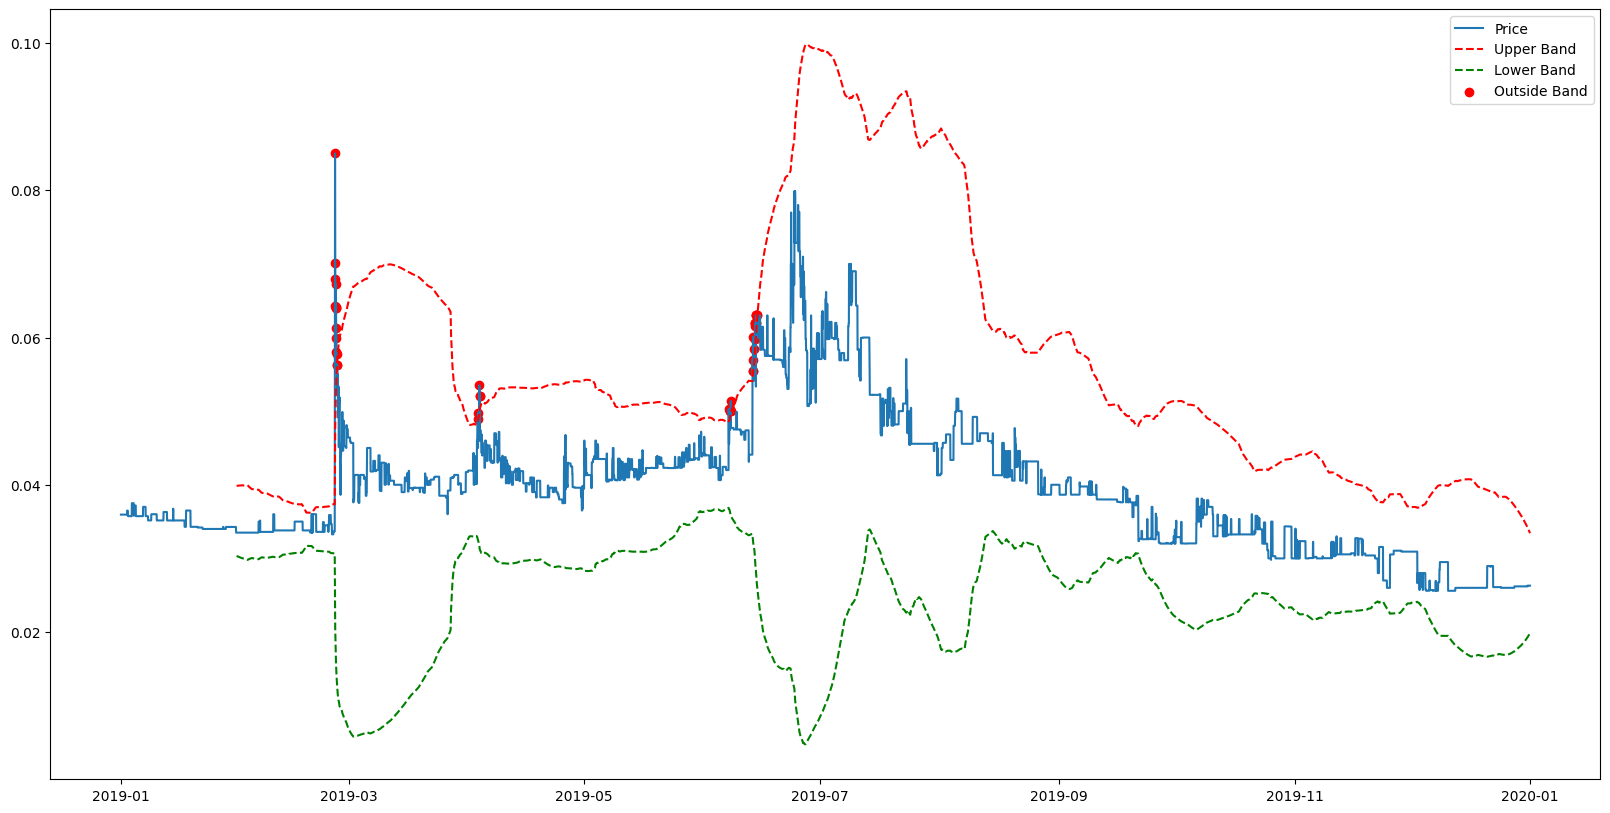

In [49]:
import matplotlib.pyplot as plt
df = close.copy()

df = df[df.index.year == 2019]
asset_name = 'rrtusd'
lookback_period = 24*30

#df['return'] = df[asset_name].pct_change()
df['std'] = df[asset_name].rolling(window = lookback_period, min_periods = lookback_period, axis = 0).std()
df['mean'] = df[asset_name].rolling(window = lookback_period, min_periods = lookback_period, axis = 0).mean()
df['Upper Band'] = df['mean']+ (5 * df['std'])
df['Lower Band'] = df['mean'] - (5 * df['std'])

# Plotting the price series with bands
plt.figure(figsize=(20, 10))
plt.plot(df.index, df[asset_name], label='Price')
plt.plot(df.index, df['Upper Band'], 'r--', label='Upper Band')
plt.plot(df.index, df['Lower Band'], 'g--', label='Lower Band')

# Highlighting points outside the band
outside_band = df[(df[asset_name]> df['Upper Band']) | (df[asset_name] < df['Lower Band'])]
plt.scatter(outside_band.index, outside_band[asset_name], color='red', label='Outside Band')
plt.legend()

Let's see what happens in Feb 2019

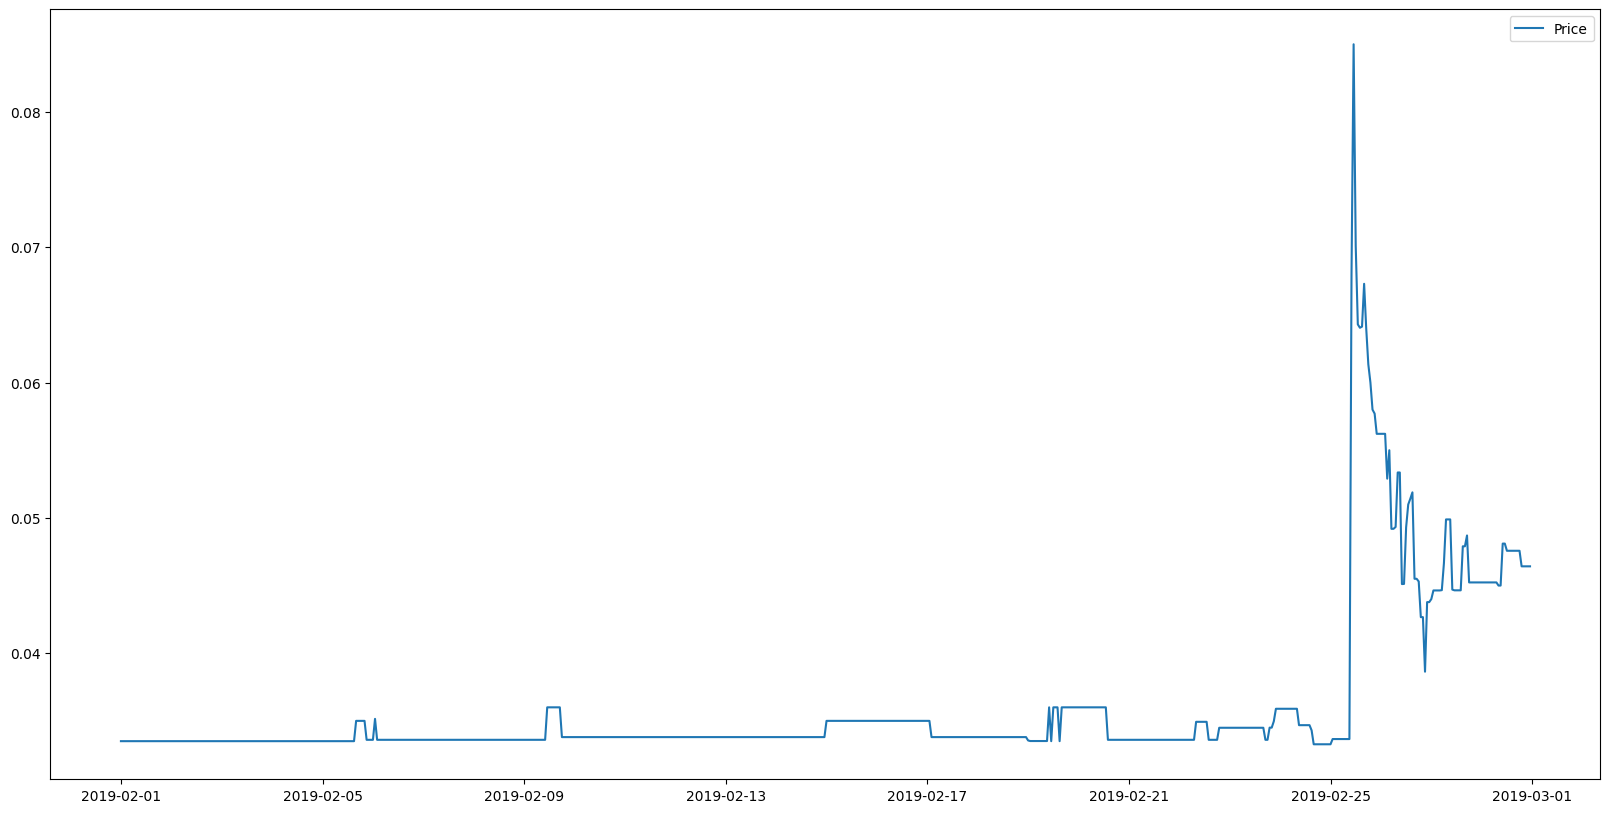

In [58]:
import matplotlib.pyplot as plt
df = close.copy()

df = df[(df.index.year == 2019) & (df.index.month == 2)]
asset_name = 'rrtusd'
lookback_period = 24
plt.figure(figsize=(20, 10))
plt.plot(df.index, df[asset_name], label='Price')
plt.legend()

The crypto currency seems to experience a price shock. Considering the focus of this project, I will not spend more time on the data cleaning part. So it's still possible to have some errors in our price dataset. 